In [1]:
# %reset
# Para visualización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
from IPython.display import Audio, Markdown, Image
import pylab
import seaborn as sns

# Números y Datos
import numpy as np
import pandas as pd

# Archivos
import urllib.request
import glob

# Análisis de sonido
import spotipy 

# Machine learning
# importar los paquetes para clustering
from sklearn.preprocessing import StandardScaler

# To work with categorical types
from pandas.api.types import CategoricalDtype

# Clustering (scipy)
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster

# Clustering (sklearn)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics.pairwise import euclidean_distances

from funciones import plot_silhouette
from funciones import plot_silhouettes_and_sses
from funciones import get_silhouette_avg
from funciones import get_sse
from funciones import vanDongen

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, Isomap, SpectralEmbedding, TSNE

Se cargan los datasets.

In [2]:
metadata_original = pd.read_csv('../data/metadata.csv', index_col='id')
audio_features_original = pd.read_csv('../data/audio_features.csv', index_col='id')
audio_analysis_original = pd.read_csv('../data/audio_analysis.csv', index_col='id')

In [3]:
audio_analysis_original.head()

,timbre_mean_0,timbre_mean_1,timbre_mean_2,timbre_mean_3,timbre_mean_4,timbre_mean_5,timbre_mean_6,timbre_mean_7,timbre_mean_8,timbre_mean_9,...,pitch_std_2,pitch_std_3,pitch_std_4,pitch_std_5,pitch_std_6,pitch_std_7,pitch_std_8,pitch_std_9,pitch_std_10,pitch_std_11
id,,,,,,,,,,,,,,,,,,,,,
2NChLGjZ93zqggig6DmoLL,39.573680,-53.160322,33.955933,-13.458602,10.908333,-34.851049,1.713744,0.357444,-9.248460,-3.464805,...,0.314326,0.182297,0.175415,0.315322,0.197047,0.190721,0.152499,0.315809,0.165763,0.112952
3TPucnH2T71lgcmhsTZVMT,37.806990,26.905931,45.066553,-1.566750,19.836837,-10.684136,-37.983923,-10.510028,-5.820575,-1.746866,...,0.293350,0.250039,0.339806,0.311496,0.260636,0.341519,0.176243,0.284082,0.300141,0.236217
5ruWnyGX0r6v8b2JisDHDo,50.307463,65.649677,-17.158870,-1.660690,30.536530,-47.617183,1.200309,1.357931,-2.241743,4.456728,...,0.361503,0.331288,0.333903,0.320905,0.290592,0.337753,0.306255,0.320579,0.347926,0.315364
4ZEVoBaSKdJfpeunWmyQfs,38.453838,-46.715751,-16.638915,-3.838850,34.693517,-27.530044,5.632033,2.938340,7.223357,-0.045737,...,0.211055,0.172432,0.307475,0.226574,0.209167,0.271316,0.221715,0.297126,0.209825,0.216391
66aVNocFLApjTfudNYVEiF,52.072411,98.597172,-16.693923,0.843767,42.616539,-42.602253,-3.609067,11.836476,2.011623,0.462091,...,0.277745,0.307850,0.362859,0.300253,0.295673,0.236315,0.301466,0.244227,0.257769,0.281606


Se seleccionan únicamente las variables numéricas

In [4]:
audio_features = audio_features_original[['acousticness','danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness','loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']]

Se estandarizan ambos datasets

In [5]:
ss = StandardScaler()
audio_features_norm = pd.DataFrame(ss.fit_transform(audio_features))
audio_analysis_norm = pd.DataFrame(ss.fit_transform(audio_analysis_original))

In [6]:
audio_features_norm.dtypes

0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
dtype: object

In [7]:
audio_features_norm.shape

(2206, 13)

In [8]:
audio_analysis_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,-0.115520,-0.540928,0.825532,-0.517760,-0.815673,-0.545354,0.385212,-0.071264,-0.246519,-0.770671,...,0.635927,-0.880266,-1.368356,0.657012,-0.893242,-1.271658,-1.552038,0.582522,-1.294840,-2.142945
1,-0.324401,0.543663,1.124139,0.195160,-0.345128,1.349489,-2.666920,-1.580151,0.185164,-0.410410,...,0.328710,0.050721,1.016125,0.604051,0.023019,0.912194,-1.208799,0.109836,0.612856,-0.382209
2,1.153568,1.068492,-0.548219,0.189529,0.218761,-1.546301,0.345737,0.067648,0.635857,0.890518,...,1.326878,1.167352,0.930504,0.734291,0.454653,0.857644,0.670610,0.653587,1.291240,0.748323
3,-0.247922,-0.453629,-0.534244,0.058947,0.437840,0.028661,0.686468,0.287079,1.827823,-0.053674,...,-0.876571,-1.015847,0.547178,-0.571438,-0.718605,-0.104483,-0.551468,0.304171,-0.669320,-0.665406
4,1.362243,1.514805,-0.535723,0.339671,0.855394,-1.153098,-0.024029,1.522535,1.171495,0.052821,...,0.100159,0.845231,1.350518,0.448427,0.527866,-0.611367,0.601389,-0.483953,0.011315,0.266129


# Experiencia 1: KMeans

## audio_features

Para audio_features, se determina la cantidad de clusters utilizando silhuette y SSE.

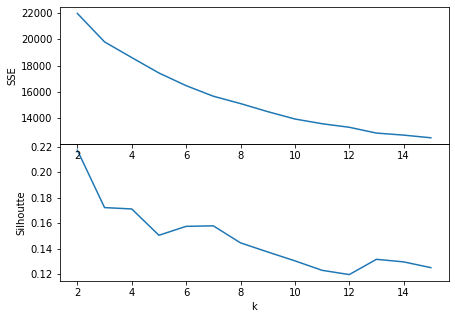

In [9]:
plot_silhouettes_and_sses(audio_features_norm, 15)

¿Cuál sería el k ideal? El quiebre de SSE lo tenemos más o menos en 5 o en 6. Con valores más altos de k el silhouette baja demasiado.

In [10]:
get_silhouette_avg(audio_features_norm, 5)

0.15054471338691172

In [11]:
get_silhouette_avg(audio_features_norm, 6)

0.15752587641457771

El silhouette promedio obtenido en 5 es mayor que en 6. Ya con 7 y 8 el silhouette parece bajar demasiado y no obtenemos mucha ganancia en el SSE.

In [12]:
get_sse(audio_features_norm, 5)

17435.734892009554

In [13]:
get_sse(audio_features_norm, 6)

16472.60619874562

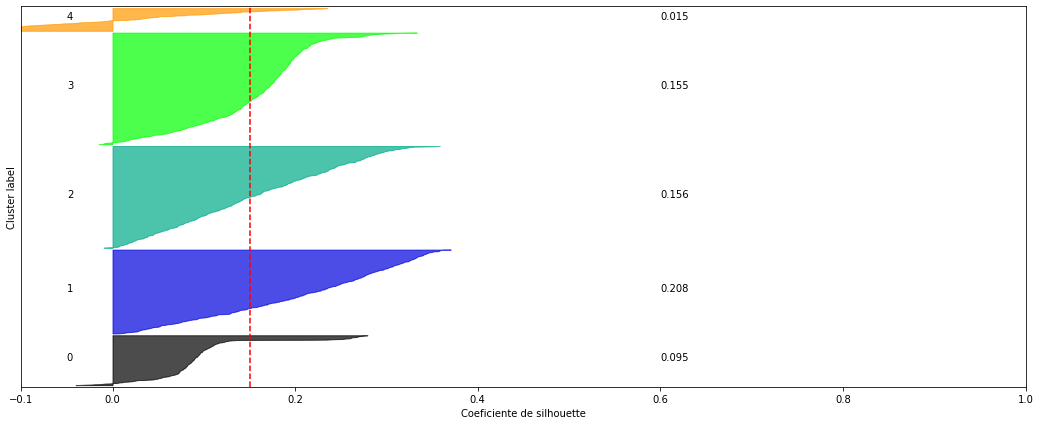

In [14]:
plot_silhouette(audio_features_norm, 5)

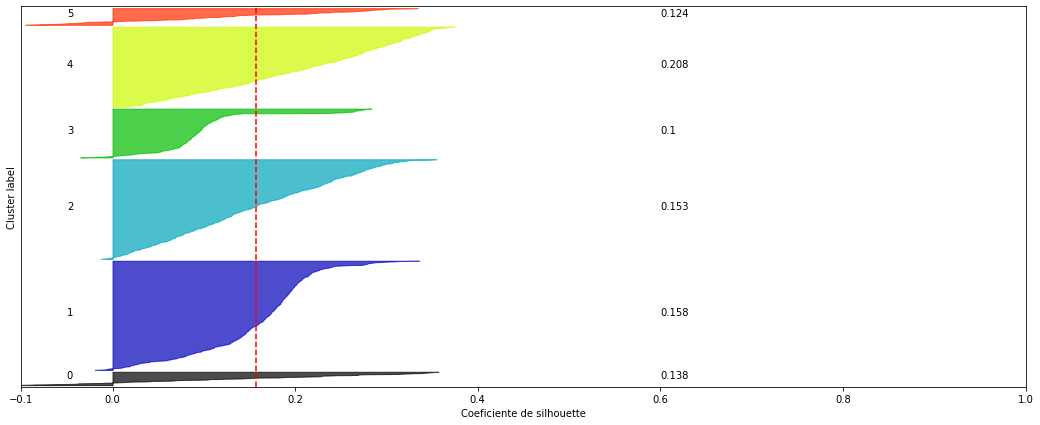

In [15]:
plot_silhouette(audio_features_norm, 6)

Conclusión: Estandarizado el dataset, da bastante mal. Para audio_features, los resultados sin estandarizar dan mucho mejor.

## audio_analysis

Para audio_analysis, se determina la cantidad de clusters utilizando silhuette y SSE.

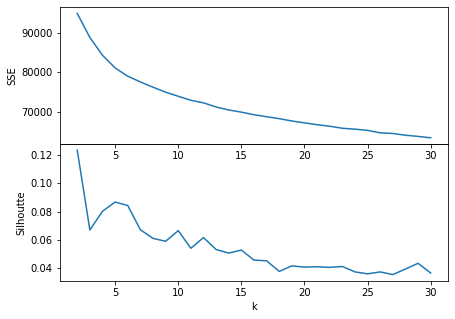

In [16]:
plot_silhouettes_and_sses(audio_analysis_norm, 30)

¿Qué valor de k podría ser mejor? Pareciera estar entre k = 3 y k = 10.

In [17]:
sils_sses = []
for k in range(3, 11):
    sils_sses.append([k, get_silhouette_avg(audio_analysis_norm, k), get_sse(audio_analysis_norm, k)])
pd.DataFrame(sils_sses, columns=['k', 'silhouette', 'sse'])

,k,silhouette,sse
0,3,0.067023,88841.584062
1,4,0.080307,84317.255825
2,5,0.086857,81092.694373
3,6,0.084383,79005.811485
4,7,0.067214,77532.438186
5,8,0.061073,76197.325827
6,9,0.059023,74937.429754
7,10,0.066569,73894.210414


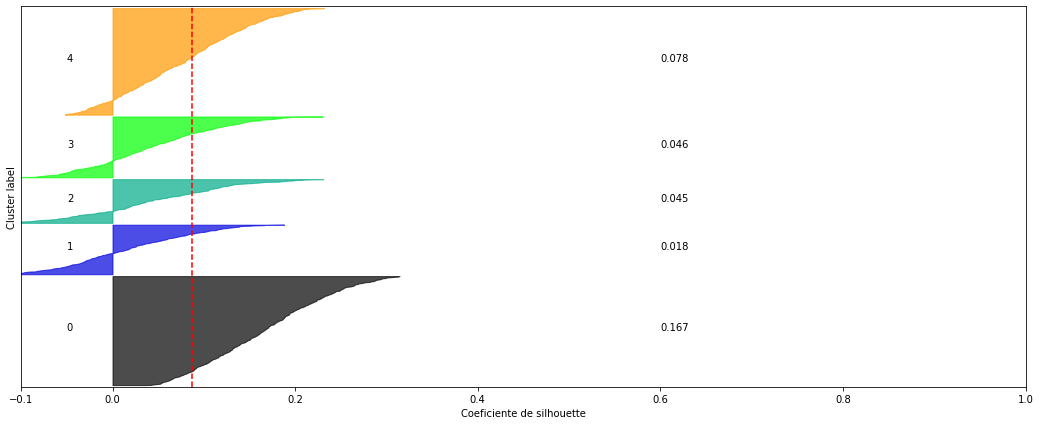

In [18]:
plot_silhouette(audio_analysis_norm, 5)

## audio_features y audio_analysis

Para ambos dataset mergeados, se determina la cantidad de clusters utilizando silhuette y SSE, estandarizando el merge previamente.

In [19]:
audio_tracks = pd.merge(audio_features, audio_analysis_original, how = 'inner', on = 'id')
audio_tracks = pd.DataFrame(ss.fit_transform(audio_tracks))
audio_tracks.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,1.020308,0.450249,-0.392925,-1.029774,-1.301087,-1.488472,-0.231377,-0.515989,0.904327,-0.205289,...,1.415470,-0.884759,1.269335,0.679161,-0.730955,0.226456,-0.145294,0.728330,-0.547664,-0.071572
1,1.010123,0.222328,-0.417935,-1.264884,-1.304228,-0.355646,-0.489057,-1.177801,0.904327,0.002644,...,-1.005882,0.457681,0.885786,-0.640365,0.693530,-0.594453,1.042249,0.357767,-0.719974,1.617699
2,1.101787,-0.223153,-0.807368,-0.899502,1.021701,-0.072439,1.044453,-0.854466,-1.105795,-0.467548,...,-0.949252,0.554463,-0.464794,1.100680,-0.328086,0.846896,1.249981,-0.845263,1.403997,0.434854
3,-0.973386,0.123908,1.992265,1.032863,0.494010,1.060387,3.244160,0.466350,-1.105795,1.624898,...,0.130184,-0.086919,0.627974,-0.059042,-0.140321,0.242723,-0.084219,0.587382,0.218605,0.381715
4,-0.306275,0.077288,0.048057,0.189198,1.001209,1.343593,-0.413638,0.120425,-1.105795,-0.512506,...,-0.283136,1.348096,0.592912,0.251442,0.241819,-0.145624,-0.198483,-0.167857,0.312347,-1.035310


In [20]:
audio_tracks.shape

(2205, 61)

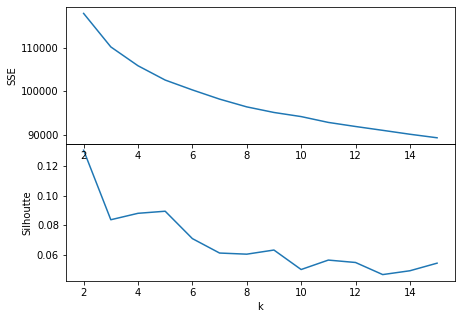

In [21]:
plot_silhouettes_and_sses(audio_tracks, 15)

Parece haber dado muy parecido a audio_features.

In [22]:
sils_sses = []
for k in range(3, 7):
    sils_sses.append([k, get_silhouette_avg(audio_tracks, k), get_sse(audio_tracks, k)])
pd.DataFrame(sils_sses, columns=['k', 'silhouette', 'sse'])

,k,silhouette,sse
0,3,0.083784,110219.401093
1,4,0.088150,105884.196082
2,5,0.089563,102595.365143
3,6,0.070984,100327.805376


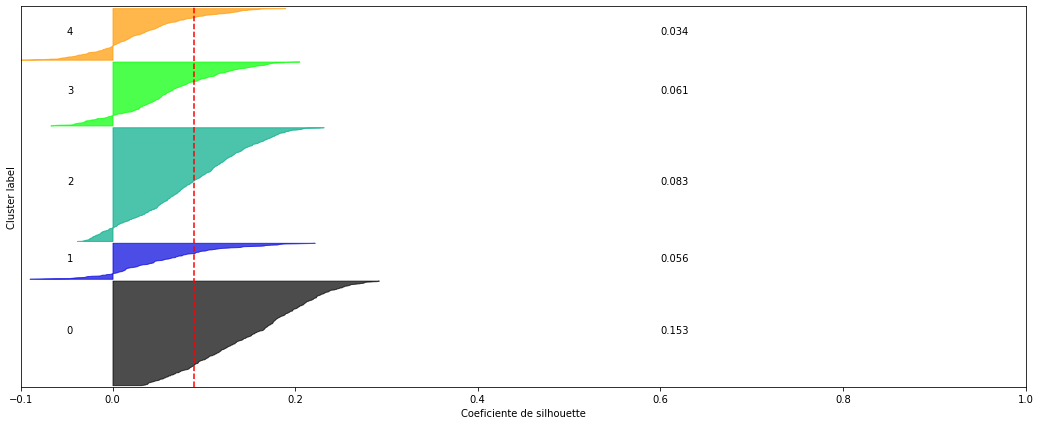

In [23]:
plot_silhouette(audio_tracks, 5)

De vuelta, audio_tracks da prácticamente lo mismo que audio_features. Parece que los summaries de audio_analysis no influyen mucho en los resultados de KMeans.

## b) Evaluar si los agrupamientos son similares para los distintos conjuntos de datos utilizando la matriz de confusión y los índices de Rand y van Dongen en los casos que correspondan

### Matrices de confusión

In [24]:
# Para que las comparaciones sean del mismo largo,
# se remueve de audio_feature el track que no se encuentra en audio_analysis
merged = audio_features.merge(audio_analysis_original, how = 'left', on = 'id')
id_to_remove = merged[merged.timbre_mean_0.isnull()].index[0]
audio_features_minus_one = audio_features.drop(id_to_remove, axis = 0)
audio_features_minus_one.shape

(2205, 13)

In [25]:
# Se ordenan los tres datasets para que los tracks estén en el mismo orden
audio_features_sorted = audio_features_minus_one.sort_index()
audio_analysis_sorted = audio_analysis_original.sort_index()
audio_tracks_sorted = audio_tracks.sort_index()

In [26]:
# Los vuelvo a estandarizar
audio_features_sorted = pd.DataFrame(ss.fit_transform(audio_features_sorted))
audio_analysis_sorted = pd.DataFrame(ss.fit_transform(audio_analysis_sorted))
audio_tracks_sorted = pd.DataFrame(ss.fit_transform(audio_tracks_sorted))

In [27]:
# Vamos a comparar todos los KMeans con k = 5
km_audio_features = KMeans(n_clusters = 5, random_state = 0).fit(audio_features_sorted)
km_audio_analysis = KMeans(n_clusters = 5, random_state = 0).fit(audio_analysis_sorted)
km_audio_tracks = KMeans(n_clusters = 5, random_state = 0).fit(audio_tracks_sorted)

In [28]:
# Matriz de confusión: audio_features VS audio_analysis
tmp1 = pd.DataFrame({'audio_features': km_audio_features.labels_, 'audio_analysis': km_audio_analysis.labels_})
ct1 = pd.crosstab(tmp1['audio_features'], tmp1['audio_analysis'])
ct1

audio_analysis,0,1,2,3,4
audio_features,,,,,
0,144,26,175,104,218
1,0,100,0,33,1
2,52,9,87,42,108
3,42,138,25,374,26
4,23,380,13,75,10


In [29]:
# Matriz de confusión: audio_features VS audio_tracks
tmp2 = pd.DataFrame({'audio_features': km_audio_features.labels_, 'audio_tracks': km_audio_tracks.labels_})
ct2 = pd.crosstab(tmp2['audio_features'], tmp2['audio_tracks'])
ct2

audio_tracks,0,1,2,3,4
audio_features,,,,,
0,191,70,204,112,90
1,38,14,36,23,23
2,85,34,85,54,40
3,172,52,187,103,91
4,137,45,166,89,64


In [30]:
# Matriz de confusión: audio_tracks VS audio_analysis
tmp3 = pd.DataFrame({'audio_tracks': km_audio_tracks.labels_, 'audio_analysis': km_audio_analysis.labels_})
ct3 = pd.crosstab(tmp3['audio_tracks'], tmp3['audio_analysis'])
ct3

audio_analysis,0,1,2,3,4
audio_tracks,,,,,
0,62,178,97,186,100
1,33,67,28,47,40
2,84,202,88,203,101
3,46,122,46,100,67
4,36,84,41,92,55


Como ya se había visto, el etiquetado de audio_features es exactamente igual que el etiquetado de audio_tracks. Lo que significa que a KMeans le da lo mismo que las variables resumen de audio_analysis estén o no en el dataset.

Los elementos que están en la diagonal son los aciertos. O sea: los que ambos modelos que se están comparando etiquetaron igual.

### Criterio de van Dongen

In [31]:
vanDongen(ct1)

0.6275080906148868

In [32]:
vanDongen(ct2)

0.9990212071778141

In [33]:
vanDongen(ct3)

0.9915556999025658

### Índices Rand

In [34]:
# audio_features VS audio_analysis
adjusted_rand_score(km_audio_features.labels_, km_audio_analysis.labels_)

0.21779725566282992

In [35]:
# audio_features VS audio_tracks
adjusted_rand_score(km_audio_features.labels_, km_audio_tracks.labels_)

0.00044868296197808616

In [36]:
# audio_analysis VS audio_tracks
adjusted_rand_score(km_audio_analysis.labels_, km_audio_tracks.labels_)

0.0017101153345048339

## c) Evaluar para los mejores casos si los clusters se coindicen con el género (columna de metadata)

Se testea primero con el que se cree que fue clustering, el de audio_features.

In [37]:
# Se remueve el track que no está en audio_analysis
metadata_minus_one = metadata_original.drop(id_to_remove, axis = 0)

# Se ordenan los index de metadata
metadata_sorted = metadata_minus_one.sort_index()
metadata_sorted.shape

(2205, 17)

In [38]:
# Se calcula la matriz de confusión
tmp4 = pd.DataFrame({'Generos': metadata_sorted.genre, 'audio_features': km_audio_features.labels_})
ct4 = pd.crosstab(tmp4['Generos'], tmp4['audio_features'])
ct4

audio_features,0,1,2,3,4
Generos,,,,,
ambient,239,6,99,34,82
classical,264,5,121,15,0
drum-and-bass,0,72,1,7,371
jazz,102,17,52,234,21
world-music,62,34,25,315,27


In [39]:
# Se calcula el criterio de van Dongen
vanDongen(ct4)

0.5621951219512196

In [40]:
# Se calcula el índice de rand
adjusted_rand_score(metadata_sorted.genre, km_audio_features.labels_)

0.2880085139944022

Se testea también, por las dudas, audio_analysis.

In [41]:
# Se calcula la matriz de confusión
tmp5 = pd.DataFrame({'Generos': metadata_sorted.genre, 'audio_analysis': km_audio_analysis.labels_})
ct5 = pd.crosstab(tmp5['Generos'], tmp5['audio_analysis'])
ct5

audio_analysis,0,1,2,3,4
Generos,,,,,
ambient,94,51,132,53,130
classical,82,15,109,26,173
drum-and-bass,3,395,5,47,1
jazz,14,68,25,297,22
world-music,68,124,29,205,37


In [42]:
# Se calcula el criterio de van Dongen
vanDongen(ct5)

0.6426836672738312

In [43]:
# Se calcula el índice de rand
adjusted_rand_score(metadata_sorted.genre, km_audio_analysis.labels_)

0.23278672368108827

Y probemos con audio_tracks

In [44]:
# Se calcula la matriz de confusión
tmp6 = pd.DataFrame({'Generos': metadata_sorted.genre, 'audio_tracks': km_audio_tracks.labels_})
ct6 = pd.crosstab(tmp6['Generos'], tmp6['audio_tracks'])
ct6

audio_tracks,0,1,2,3,4
Generos,,,,,
ambient,127,56,139,70,68
classical,120,44,112,72,57
drum-and-bass,127,38,146,83,57
jazz,125,35,143,68,55
world-music,124,42,138,88,71


In [45]:
# Se calcula el criterio de van Dongen
vanDongen(ct6)

0.9899051697766901

In [46]:
# Se calcula el índice de rand
adjusted_rand_score(metadata_sorted.genre, km_audio_tracks.labels_)

-0.0004518402560464708

## d) Visualizar los clusters y las etiquetas de género en baja dimensión con alguna técnica de reducción (PCA, TSNE, MDS, etc)

In [47]:
metadata_sorted.genre.head()

id
00At7PWydsvg7g5xgaYan9    drum-and-bass
00BgcUYkIImsDN5rNjkR1U    drum-and-bass
00WgnFIsY1y84p7mYAJRuF    drum-and-bass
00isAURAZeKQXv6CW2vckb        classical
00ne3qRgc0JqY6MNYfhWri        classical
Name: genre, dtype: object

In [48]:
genres = []
for genre in metadata_sorted.genre:
    if genre == 'ambient':
        genres.append(0)
    if genre == 'classical':
        genres.append(1)
    if genre == 'drum-and-bass':
        genres.append(2)
    if genre == 'jazz':
        genres.append(3)
    if genre == 'world-music':
        genres.append(4)
len(genres)

2205

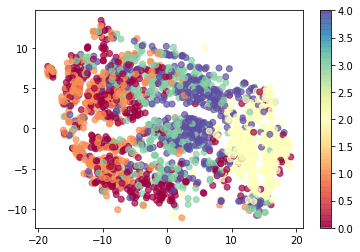

In [49]:
tsne = TSNE(n_components=2,perplexity=200)
Xred = tsne.fit_transform(audio_features_sorted)
plt.scatter(Xred[:,0], Xred[:,1], c=genres, cmap=plt.cm.Spectral, alpha=0.7)
plt.colorbar()

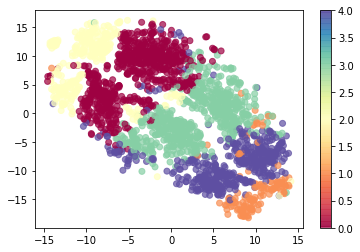

In [50]:
tsne = TSNE(n_components=2,perplexity=200)
Xred = tsne.fit_transform(audio_features_sorted)
plt.scatter(Xred[:,0], Xred[:,1], c=km_audio_features.labels_, cmap=plt.cm.Spectral, alpha=0.7)
plt.colorbar()